In [ ]:
# Cell 1: Import Libraries and Setup Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configuration
class Config:
    DATA_PATH = Path("data")
    FIG_SIZE = (12, 6)
    COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    plt.style.use('seaborn-v0_8-whitegrid')

print(" Libraries imported and configuration set up!")

 Libraries imported and configuration set up!


In [3]:
# Cell 2: Load and Clean Data Function
def load_and_clean_improved(files):
    """Load and clean multiple CSV files with error handling."""
    dfs = []
    required_cols = ['date', 'state', 'district', 'pincode']
    
    for file in files:
        try:
            df = pd.read_csv(file)
            
            # Validate required columns
            missing_cols = [col for col in required_cols if col not in df.columns]
            if missing_cols:
                print(f"Warning: {file} missing columns: {missing_cols}")
                continue
            
            # Clean column names
            df.columns = (df.columns
                         .str.lower()
                         .str.strip()
                         .str.replace(" ", "_")
                         .str.replace(".", ""))
            
            # Standardize state names
            df["state"] = (df["state"]
                          .str.replace("&", "and")
                          .str.title()
                          .str.strip())
            
            # Handle missing values strategically
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            df[numeric_cols] = df[numeric_cols].fillna(0)
            
            # Drop duplicates
            initial_len = len(df)
            df.drop_duplicates(inplace=True)
            if initial_len != len(df):
                print(f"Removed {initial_len - len(df)} duplicates from {file}")
            
            dfs.append(df)
            
        except Exception as e:
            print(f"Error loading {file}: {e}")
            continue
    
    if not dfs:
        raise ValueError("No data loaded successfully")
    
    return pd.concat(dfs, ignore_index=True)

print(" Data loading function defined!")

 Data loading function defined!


In [5]:
# Cell 3: Data Quality Analysis Function
def analyze_data_quality(df, df_name):
    """Comprehensive data quality check."""
    print(f"\n=== Data Quality Report: {df_name} ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Missing values:\n{df.isnull().sum()}")
    print(f"Duplicate rows: {df.duplicated().sum()}")
    
    # Check for negative values in numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    negative_counts = (df[numeric_cols] < 0).sum()
    if negative_counts.any():
        print(f"Negative values found:\n{negative_counts[negative_counts > 0]}")

print(" Data quality analysis function defined!")

 Data quality analysis function defined!


In [7]:
# Cell 4: Load All Datasets
print("Starting Data Analysis...")
print("=" * 50)
print("Loading data...")

# Find data files
enroll_files = glob.glob("data/enroll*.csv")
demo_files = glob.glob("data/demographic*.csv")
bio_files = glob.glob("data/biometric*.csv")

print(f"Found {len(enroll_files)} enrollment files")
print(f"Found {len(demo_files)} demographic files")
print(f"Found {len(bio_files)} biometric files")

# Load data
enrollment = load_and_clean_improved(enroll_files)
demographic = load_and_clean_improved(demo_files)
biometric = load_and_clean_improved(bio_files)

print(f"\n Data loaded successfully!")
print(f"Enrollment data shape: {enrollment.shape}")
print(f"Demographic data shape: {demographic.shape}")
print(f"Biometric data shape: {biometric.shape}")

Starting Data Analysis...
Loading data...
Found 3 enrollment files
Found 5 demographic files
Found 4 biometric files
Removed 6048 duplicates from data\enroll1.csv
Removed 15813 duplicates from data\enroll2.csv
Removed 81209 duplicates from data\demographic1.csv
Removed 8 duplicates from data\demographic2.csv
Removed 27834 duplicates from data\demographic3.csv
Removed 3 duplicates from data\demographic4.csv
Removed 2 duplicates from data\demographic5.csv
Removed 10323 duplicates from data\biometric1.csv
Removed 31227 duplicates from data\biometric2.csv
Removed 30593 duplicates from data\biometric3.csv
Removed 21313 duplicates from data\biometric4.csv

 Data loaded successfully!
Enrollment data shape: (984168, 7)
Demographic data shape: (1962644, 6)
Biometric data shape: (1767652, 6)


In [9]:
# Cell 5: Data Quality Analysis
analyze_data_quality(enrollment, "Enrollment")
analyze_data_quality(demographic, "Demographic")
analyze_data_quality(biometric, "Biometric")


=== Data Quality Report: Enrollment ===
Shape: (984168, 7)
Columns: ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater']
Missing values:
date              0
state             0
district          0
pincode           0
age_0_5           0
age_5_17          0
age_18_greater    0
dtype: int64
Duplicate rows: 1117

=== Data Quality Report: Demographic ===
Shape: (1962644, 6)
Columns: ['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_']
Missing values:
date             0
state            0
district         0
pincode          0
demo_age_5_17    0
demo_age_17_     0
dtype: int64
Duplicate rows: 364595

=== Data Quality Report: Biometric ===
Shape: (1767652, 6)
Columns: ['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_']
Missing values:
date            0
state           0
district        0
pincode         0
bio_age_5_17    0
bio_age_17_     0
dtype: int64
Duplicate rows: 1465


In [11]:
# Cell 6: Data Processing Functions
def process_enrollment_data(enrollment_df):
    """Process and aggregate enrollment data."""
    # Extract year from date if available
    if 'date' in enrollment_df.columns:
        try:
            enrollment_df['date'] = pd.to_datetime(enrollment_df['date'], errors='coerce')
            enrollment_df['year'] = enrollment_df['date'].dt.year
        except:
            enrollment_df['year'] = 2023  # Default year if parsing fails
    
    # Group by state, district, pincode, and year
    enrollment_agg = enrollment_df.groupby(['state', 'district', 'pincode', 'year']).agg({
        'age_0_5': 'sum',
        'age_5_17': 'sum',
        'age_18_greater': 'sum'
    }).reset_index()
    
    # Calculate total enrollment
    enrollment_agg['total_enrollment'] = (
        enrollment_agg['age_0_5'] + 
        enrollment_agg['age_5_17'] + 
        enrollment_agg['age_18_greater']
    )
    
    return enrollment_agg

def process_update_data(df, prefix):
    """Process demographic or biometric update data."""
    if 'date' in df.columns:
        try:
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df['year'] = df['date'].dt.year
        except:
            df['year'] = 2023
    
    # Determine age columns based on prefix
    if prefix == 'demo':
        age_cols = ['demo_age_5_17', 'demo_age_17_']
    else:  # biometric
        age_cols = ['bio_age_5_17', 'bio_age_17_']
    
    # Group and aggregate
    update_agg = df.groupby(['state', 'district', 'pincode', 'year']).agg({
        age_cols[0]: 'sum',
        age_cols[1]: 'sum'
    }).reset_index()
    
    # Rename columns
    update_agg = update_agg.rename(columns={
        age_cols[0]: f'{prefix}_age_5_17',
        age_cols[1]: f'{prefix}_age_17_plus'
    })
    
    # Calculate total updates
    update_agg[f'total_{prefix}_updates'] = (
        update_agg[f'{prefix}_age_5_17'] + 
        update_agg[f'{prefix}_age_17_plus']
    )
    
    return update_agg

print(" Data processing functions defined!")

 Data processing functions defined!


In [13]:
# Cell 7: Process and Aggregate Data
print("\nProcessing data...")

# Process each dataset
enrollment_agg = process_enrollment_data(enrollment)
demo_agg = process_update_data(demographic, 'demo')
bio_agg = process_update_data(biometric, 'bio')

print(f"Enrollment aggregated shape: {enrollment_agg.shape}")
print(f"Demographic aggregated shape: {demo_agg.shape}")
print(f"Biometric aggregated shape: {bio_agg.shape}")


Processing data...
Enrollment aggregated shape: (27051, 8)
Demographic aggregated shape: (30226, 7)
Biometric aggregated shape: (30039, 7)


In [15]:
# Cell 8: Merge Datasets
def merge_datasets(enrollment_agg, demo_agg, bio_agg):
    """Merge all three datasets."""
    # Merge enrollment with demographic
    merged = pd.merge(enrollment_agg, demo_agg, 
                     on=['state', 'district', 'pincode', 'year'],
                     how='outer')
    
    # Merge with biometric
    merged = pd.merge(merged, bio_agg,
                     on=['state', 'district', 'pincode', 'year'],
                     how='outer')
    
    # Fill NaN values with 0
    merged = merged.fillna(0)
    
    return merged

# Merge datasets
merged = merge_datasets(enrollment_agg, demo_agg, bio_agg)

print(f"\n✅ Datasets merged successfully!")
print(f"Merged dataset shape: {merged.shape}")
print(f"Merged dataset columns: {list(merged.columns)}")


✅ Datasets merged successfully!
Merged dataset shape: (31656, 14)
Merged dataset columns: ['state', 'district', 'pincode', 'year', 'age_0_5', 'age_5_17', 'age_18_greater', 'total_enrollment', 'demo_age_5_17', 'demo_age_17_plus', 'total_demo_updates', 'bio_age_5_17', 'bio_age_17_plus', 'total_bio_updates']


In [17]:
# Cell 9: Advanced Insights
print("\n=== Advanced Insights ===")

# Growth rate calculation (if multi-year data)
if 'year' in merged.columns and merged['year'].nunique() > 1:
    yearly_growth = merged.groupby('year')[['total_enrollment', 
                                            'total_demo_updates', 
                                            'total_bio_updates']].sum()
    yearly_growth_pct = yearly_growth.pct_change() * 100
    print(f"\nYearly Growth Rates (%):\n{yearly_growth_pct}")
else:
    print("\nSingle year data - growth rate calculation skipped")

# Anomaly detection
merged['enrollment_to_update_ratio'] = (
    merged['total_enrollment'] / merged['total_demo_updates'].replace(0, 1))

anomalies = merged[merged['enrollment_to_update_ratio'] < 0.01]
if not anomalies.empty:
    print(f"\nPotential Anomalies (Low Enrollment/Update Ratio):")
    print(anomalies[['state', 'district', 'enrollment_to_update_ratio']].head())
else:
    print("\nNo anomalies detected")


=== Advanced Insights ===

Single year data - growth rate calculation skipped

Potential Anomalies (Low Enrollment/Update Ratio):
                         state  district  enrollment_to_update_ratio
2  Andaman And Nicobar Islands  Andamans                         0.0
5  Andaman And Nicobar Islands  Andamans                         0.0
7  Andaman And Nicobar Islands  Andamans                         0.0
8  Andaman And Nicobar Islands  Andamans                         0.0
9  Andaman And Nicobar Islands  Andamans                         0.0


In [19]:
# Cell 10: Create Visualization Functions
def create_activity_distribution_pie(merged_df):
    """Create pie chart showing activity distribution."""
    plt.figure(figsize=(10, 8))
    
    # Calculate activity totals
    activity_totals = merged_df[['total_enrollment', 'total_demo_updates', 
                                 'total_bio_updates']].sum()
    
    # Create labels with percentages
    labels = ['Enrollment', 'Demographic Updates', 'Biometric Updates']
    
    # Plot pie chart
    wedges, texts, autotexts = plt.pie(activity_totals, labels=labels, 
                                       autopct='%1.1f%%', colors=Config.COLORS[:3],
                                       startangle=90, explode=(0.05, 0.05, 0.05))
    
    # Customize text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)
    
    plt.title('Activity Distribution Across All Records', fontsize=16, fontweight='bold', pad=20)
    plt.legend(wedges, [f'{label}: {val:,}' for label, val in zip(labels, activity_totals)],
               loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("Activity Distribution Summary:")
    for label, val in zip(labels, activity_totals):
        print(f"  {label}: {val:,} records")
    print(f"\nTotal Activities: {activity_totals.sum():,}")

def create_top_states_barchart(merged_df):
    """Create horizontal bar chart of top states by biometric updates."""
    plt.figure(figsize=(12, 8))
    
    # Calculate top states by biometric updates
    top_states = (merged_df.groupby('state')['total_bio_updates']
                  .sum()
                  .nlargest(15)
                  .sort_values())
    
    # Create horizontal bar chart
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_states)))
    bars = plt.barh(top_states.index, top_states.values, color=colors, edgecolor='black')
    
    # Add value labels on bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width * 1.01, bar.get_y() + bar.get_height()/2,
                f'{width:,.0f}', va='center', fontsize=10)
    
    plt.title('Top 15 States by Biometric Updates', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Number of Biometric Updates (Millions)', fontsize=12)
    plt.ylabel('State', fontsize=12)
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Format x-axis to show in millions
    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    
    plt.tight_layout()
    plt.show()
    
    # Print top 5 states
    print("Top 5 States by Biometric Updates:")
    for i, (state, count) in enumerate(top_states.tail(5).items()):
        print(f"  {i+1}. {state}: {count:,.0f} updates")

def create_age_distribution_chart(merged_df):
    """Create bar chart showing age-wise enrollment distribution."""
    plt.figure(figsize=(10, 7))
    
    # Calculate age totals
    age_cols = ['age_0_5', 'age_5_17', 'age_18_greater']
    age_labels = ['0-5 Years', '5-17 Years', '18+ Years']
    age_totals = merged_df[age_cols].sum()
    
    # Create bar chart
    bars = plt.bar(age_labels, age_totals.values, 
                   color=Config.COLORS[:3], edgecolor='black', linewidth=2)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height * 1.01,
                f'{height:,.0f}', ha='center', va='bottom', fontsize=11)
    
    plt.title('Age-wise Enrollment Distribution', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Number of Enrollments', fontsize=12)
    plt.xlabel('Age Groups', fontsize=12)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add percentage labels
    total_enrollment = age_totals.sum()
    percentages = (age_totals / total_enrollment * 100).round(1)
    
    for i, (label, pct) in enumerate(zip(age_labels, percentages)):
        plt.text(i, age_totals[i] * 0.5, f'{pct}%', 
                ha='center', va='center', color='white', 
                fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("Age Distribution Statistics:")
    for label, total, pct in zip(age_labels, age_totals, percentages):
        print(f"  {label}: {total:,.0f} ({pct}%)")
    print(f"\nTotal Enrollment: {total_enrollment:,.0f}")

def create_correlation_heatmap(merged_df):
    """Create correlation heatmap of key metrics."""
    plt.figure(figsize=(10, 8))
    
    # Select numeric columns for correlation
    numeric_cols = ['total_enrollment', 'total_demo_updates', 
                    'total_bio_updates', 'age_0_5', 
                    'age_5_17', 'age_18_greater']
    
    # Filter to only include columns that exist
    numeric_cols = [col for col in numeric_cols if col in merged_df.columns]
    
    # Calculate correlation matrix
    corr_matrix = merged_df[numeric_cols].corr()
    
    # Create heatmap
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
                cmap='coolwarm', center=0, square=True,
                linewidths=1, linecolor='white',
                cbar_kws={'shrink': 0.8})
    
    plt.title('Correlation Matrix of Key Metrics', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print top correlations
    print("Top Positive Correlations (>0.7):")
    corr_pairs = corr_matrix.unstack()
    sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)
    
    for i in range(len(sorted_pairs)):
        if sorted_pairs.index[i][0] != sorted_pairs.index[i][1]:  # Skip self-correlations
            if sorted_pairs[i] > 0.7:
                print(f"  {sorted_pairs.index[i][0]} ↔ {sorted_pairs.index[i][1]}: {sorted_pairs[i]:.3f}")

def create_enrollment_vs_updates_scatter(merged_df):
    """Create scatter plot comparing enrollment vs updates."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Sample data for better visualization
    sample_data = merged_df.sample(n=1000, random_state=RANDOM_SEED)
    
    # Plot 1: Enrollment vs Demographic Updates
    scatter1 = axes[0].scatter(sample_data['total_enrollment'], 
                              sample_data['total_demo_updates'],
                              c=sample_data['total_bio_updates'],
                              cmap='viridis', alpha=0.6, s=50)
    axes[0].set_xlabel('Total Enrollment', fontsize=12)
    axes[0].set_ylabel('Demographic Updates', fontsize=12)
    axes[0].set_title('Enrollment vs Demographic Updates', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0], label='Biometric Updates')
    
    # Plot 2: Demographic vs Biometric Updates
    scatter2 = axes[1].scatter(sample_data['total_demo_updates'], 
                              sample_data['total_bio_updates'],
                              c=sample_data['total_enrollment'],
                              cmap='plasma', alpha=0.6, s=50)
    axes[1].set_xlabel('Demographic Updates', fontsize=12)
    axes[1].set_ylabel('Biometric Updates', fontsize=12)
    axes[1].set_title('Demographic vs Biometric Updates', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[1], label='Total Enrollment')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate overall ratios
    print("Update Ratios:")
    demo_ratio = merged_df['total_demo_updates'].sum() / merged_df['total_enrollment'].sum()
    bio_ratio = merged_df['total_bio_updates'].sum() / merged_df['total_enrollment'].sum()
    print(f"  Demographic Updates per Enrollment: {demo_ratio:.3f}")
    print(f"  Biometric Updates per Enrollment: {bio_ratio:.3f}")

print("✅ Visualization functions defined!")

✅ Visualization functions defined!


Creating Visualizations...

1. Activity Distribution Pie Chart


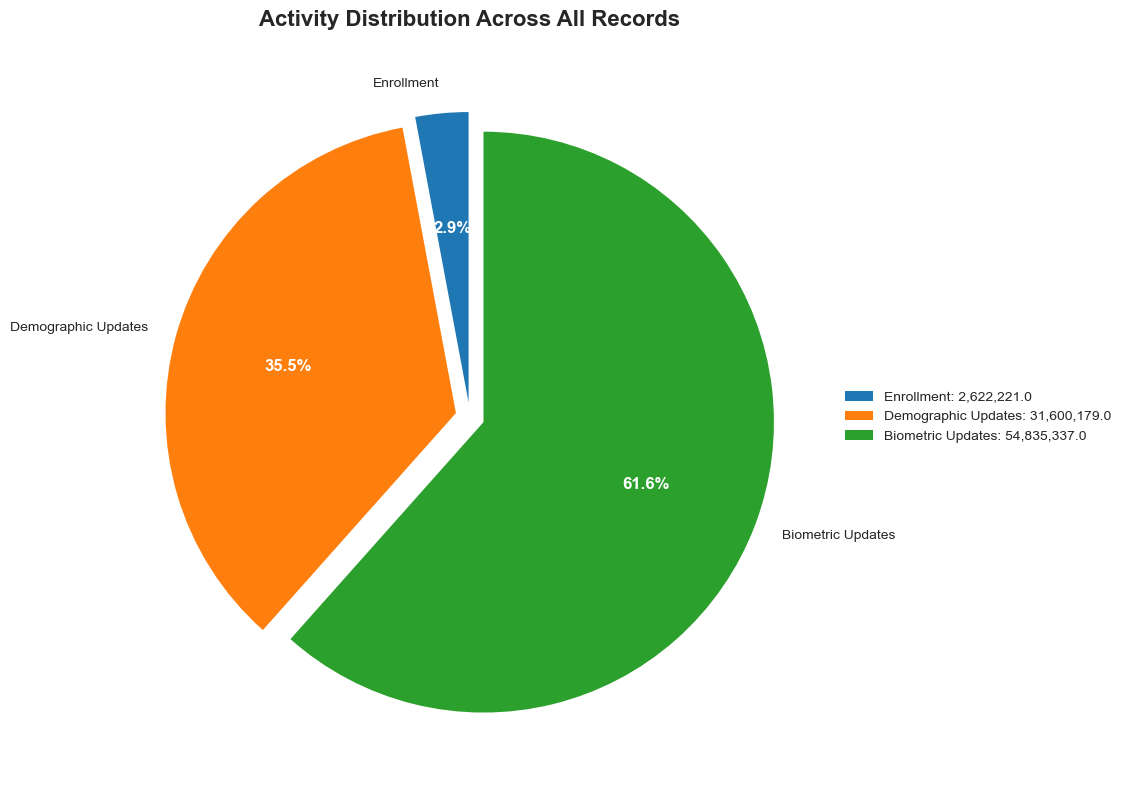

Activity Distribution Summary:
  Enrollment: 2,622,221.0 records
  Demographic Updates: 31,600,179.0 records
  Biometric Updates: 54,835,337.0 records

Total Activities: 89,057,737.0


In [21]:
# Cell 11: Generate All Visualizations
print("=" * 50)
print("Creating Visualizations...")
print("=" * 50)

# 1. Activity Distribution Pie Chart
print("\n1. Activity Distribution Pie Chart")
create_activity_distribution_pie(merged)


2. Top States by Biometric Updates


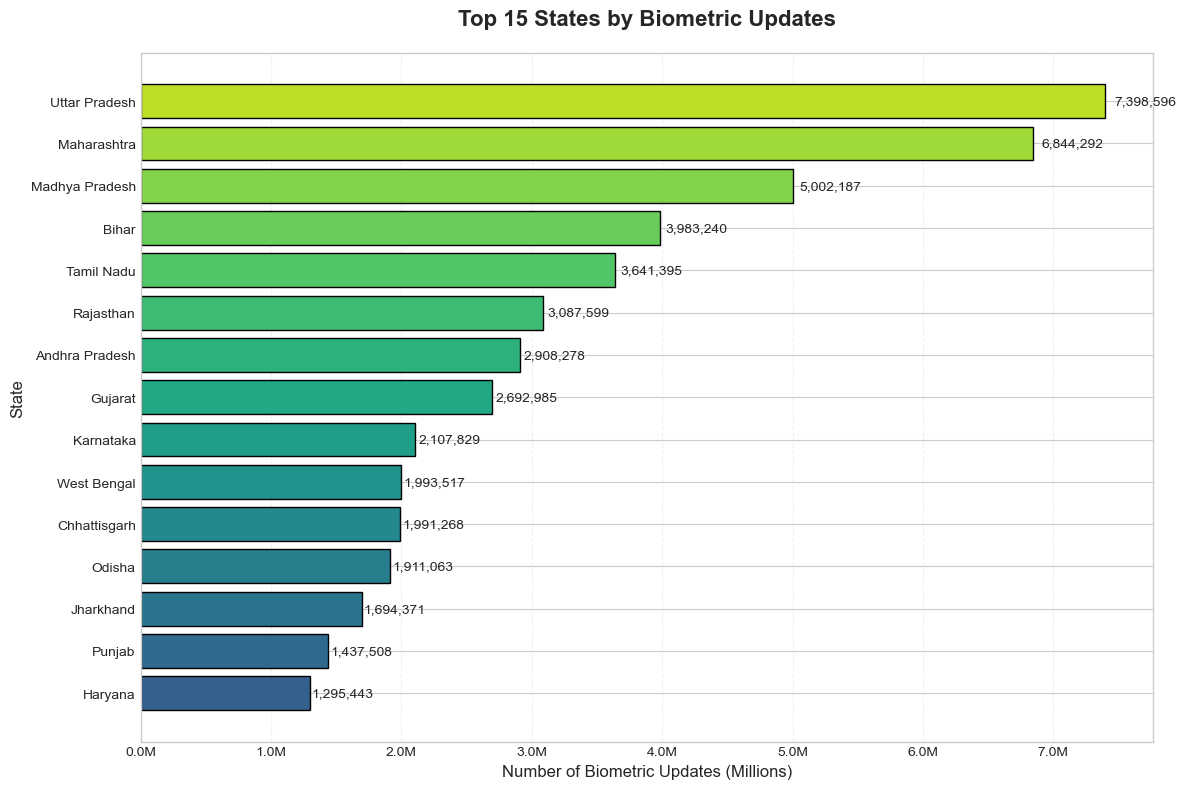

Top 5 States by Biometric Updates:
  1. Tamil Nadu: 3,641,395 updates
  2. Bihar: 3,983,240 updates
  3. Madhya Pradesh: 5,002,187 updates
  4. Maharashtra: 6,844,292 updates
  5. Uttar Pradesh: 7,398,596 updates


In [23]:
# Cell 12: Top States by Biometric Updates
print("\n2. Top States by Biometric Updates")
create_top_states_barchart(merged)


3. Age Distribution Chart


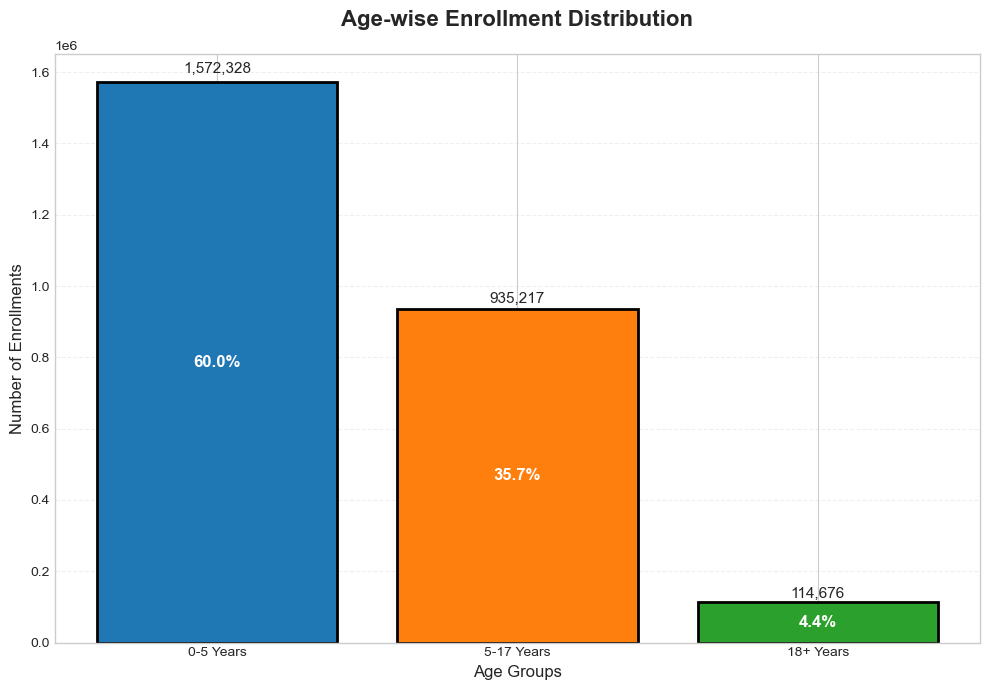

Age Distribution Statistics:
  0-5 Years: 1,572,328 (60.0%)
  5-17 Years: 935,217 (35.7%)
  18+ Years: 114,676 (4.4%)

Total Enrollment: 2,622,221


In [25]:
# Cell 13: Age Distribution Chart
print("\n3. Age Distribution Chart")
create_age_distribution_chart(merged)


4. Correlation Heatmap


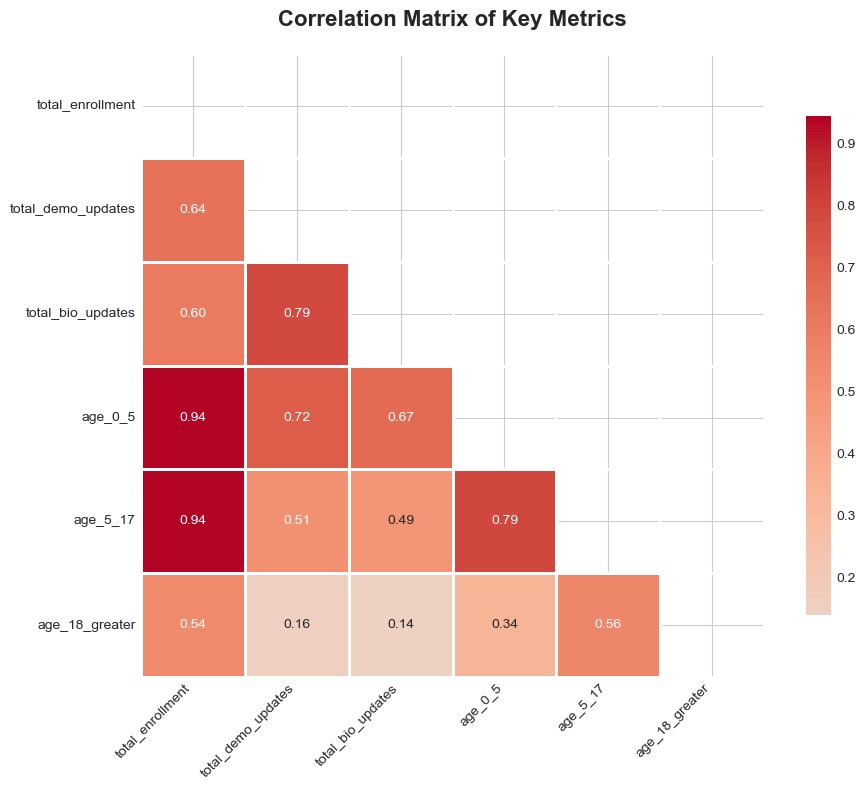

Top Positive Correlations (>0.7):
  total_enrollment ↔ age_0_5: 0.944
  age_0_5 ↔ total_enrollment: 0.944
  age_5_17 ↔ total_enrollment: 0.943
  total_enrollment ↔ age_5_17: 0.943
  age_0_5 ↔ age_5_17: 0.795
  age_5_17 ↔ age_0_5: 0.795
  total_bio_updates ↔ total_demo_updates: 0.786
  total_demo_updates ↔ total_bio_updates: 0.786
  total_demo_updates ↔ age_0_5: 0.715
  age_0_5 ↔ total_demo_updates: 0.715


In [27]:
# Cell 14: Correlation Heatmap
print("\n4. Correlation Heatmap")
create_correlation_heatmap(merged)


5. Enrollment vs Updates Scatter Plot


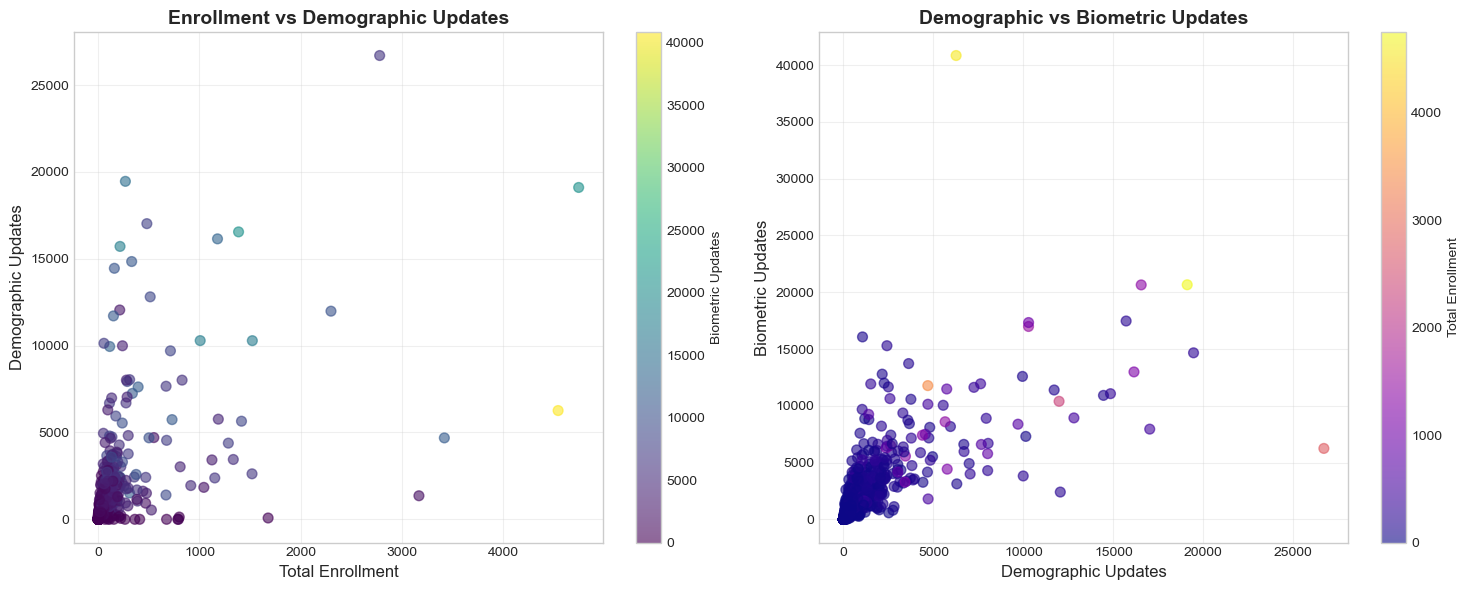

Update Ratios:
  Demographic Updates per Enrollment: 12.051
  Biometric Updates per Enrollment: 20.912


In [29]:
# Cell 15: Enrollment vs Updates Scatter Plot
print("\n5. Enrollment vs Updates Scatter Plot")
create_enrollment_vs_updates_scatter(merged)

In [31]:
# Cell 16: Summary Statistics
print("\n" + "=" * 50)
print("SUMMARY STATISTICS")
print("=" * 50)

# Basic statistics
print(f"\nTotal Records Processed: {len(merged):,}")
print(f"Number of States: {merged['state'].nunique()}")
print(f"Number of Districts: {merged['district'].nunique()}")
print(f"Number of Pincodes: {merged['pincode'].nunique()}")

# Top performing states
print("\nTop 5 States by Total Activities:")
total_by_state = merged.groupby('state')[['total_enrollment', 'total_demo_updates', 'total_bio_updates']].sum()
total_by_state['total_activities'] = total_by_state.sum(axis=1)
top_states = total_by_state['total_activities'].nlargest(5)
for i, (state, total) in enumerate(top_states.items(), 1):
    print(f"  {i}. {state}: {total:,.0f} activities")

# Year analysis
print(f"\nData Year Range: {int(merged['year'].min())} - {int(merged['year'].max())}")
if merged['year'].nunique() > 1:
    print("Multi-year analysis available")
else:
    print(f"Single year analysis ({int(merged['year'].unique()[0])})")

print("\n✅ Analysis Complete!")


SUMMARY STATISTICS

Total Records Processed: 31,656
Number of States: 48
Number of Districts: 1005
Number of Pincodes: 19736

Top 5 States by Total Activities:
  1. Uttar Pradesh: 13,345,408 activities
  2. Maharashtra: 9,738,469 activities
  3. Madhya Pradesh: 7,435,562 activities
  4. Bihar: 7,091,775 activities
  5. Rajasthan: 5,333,212 activities

Data Year Range: 2025 - 2025
Single year analysis (2025)

✅ Analysis Complete!
